In [ ]:
%run ./msgc_experiments_ct_init.ipynb
# the other imports are not necessary

In [1]:
%pylab inline

import sys
import os.path as op
from pathlib import Path
import shutil
# sys.path.insert(0, "/home/mjirik/projects/pyseg_base/")
sys.path.insert(0, op.abspath("../"))
import scipy
import time
import pandas as pd

from imcut import pycut
import sed3
import itertools
import data2tex as dtt
import io3d

latex_dir = Path("../../papers/cmbbeiv19/tmp/")
dtt.set_output(latex_dir)

# sh 155,160, r10, dpoff 3, seeds 3
# dp_ircad_id = [1, 11]
# dp_ircad_id = [1, 5, 6, 7]
dp_ircad_id = [1, 5, 6, 7, 11, 20]
# dp_ircad_id = [11, 20]
# dp_ircad_id = [1]
dp_keys = ["left_kidney"]

dp_ircad_id_key = [
#     [1, "left_kidney"],
#     [5, "left_kidney"],
#     [6, "left_kidney"],
#     [7, "left_kidney"],
#     [11, "left_kidney"],
#     [20, "left_kidney"],
    [3, "right_kidney"],
]

working_voxelsize_mm = None
# working_voxelsize_mm = [1.5, 1.5, 1.5]
working_voxelsize_mm = [1.3, 1.3, 1.3]
# working_voxelsize_mm = [1.7, 1.7, 1.7]
# working_voxelsize_mm = "orig*2"
# working_voxelsize_mm=[2, 2, 2]
# working_voxelsize_mm=[2.2, 2.5, 2.5]

fname = "exp062-multiscale_delme.csv"
fnamenew = "msgc_experiment_ct.csv"

rnd_seed=1

dpi = 400

Populating the interactive namespace from numpy and matplotlib


In [2]:
# dry_run = True
dry_run = False
force_rewrite = False
# force_rewrite = True


In [3]:
%pwd

'C:\\Users\\Jirik\\projects\\imcut\\examples'

## Methods setup

In [4]:
# block size bylo 10
segparams0 = {
    'method':'graphcut',
#     'method':'multiscale_graphcut',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }

segparams1 = {
    # 'method':'graphcut',
    'method':'multiscale_graphcut_hi2lo',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }

segparams2 = {
    # 'method':'graphcut',
    'method':'multiscale_graphcut_lo2hi',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }


labels = [
    "ssgc ",
    "msgc_hi2lo ",
    "msgc_lo2hi ",
]



In [5]:
data_seeds_path = Path(io3d.datasets.join_path("medical", "orig", "ircad1b_seeds", get_root=True)) 
d01_pth = data_seeds_path / "ircadb1-01.pklz"

datap = io3d.read(d01_pth)
datap
str(d01_pth)
datap.keys()


dict_keys(['series_number', 'datadir', 'voxelsize_mm', 'version', 'crinfo', 'segmentation', 'apriori', 'slab', 'orig_shape', 'vessel_tree', 'saved_seeds', 'processing_information', 'experiment_caption', 'lisa_operator_identifier', 'data3d'])

In [6]:
# io3d.write(datap, data_seeds_path / "ircad1b01.hdf5")
# io3d.read(data_seeds_path / "ircad1b01.hdf5")

In [7]:
# datap['saved_seeds']["left_kidney"]

In [8]:
# pth_data3d = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "PATIENT_DICOM", get_root=True)) 
# pth_ground_true = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "MASKS_DICOM", "{}"  get_root=True)) 
# pth_seeds = Path(io3d.datasets.join_path("medical", "orig", "ircad1b_seeds", "ircad1b{:02d}.pklz", get_root=True)) 
# print(pth_data3d)
# print(pth_seeds)

In [9]:
import imma
help(imma.image_manipulation.resize_to_mm)

Help on function resize_to_mm in module imma.image:

resize_to_mm(data3d, voxelsize_mm, new_voxelsize_mm, mode='reflect', order=1)
    Function can resize data3d or segmentation to specifed voxelsize_mm
    :new_voxelsize_mm: requested voxelsize. List of 3 numbers, also
        can be a string 'orig', 'orig*2' and 'orig*4'.
    
    :voxelsize_mm: size of voxel
    :mode: default is 'edge'. Modes match the behaviour of numpy.pad



In [10]:
def prepare_data(i, seeds_key):
    ground_true_key = seeds_key.replace("_", "")
    pth_data3d = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "PATIENT_DICOM", get_root=True)) 
    pth_ground_true = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "MASKS_DICOM", "{}", get_root=True)) 
    pth_seeds = Path(io3d.datasets.join_path("medical", "orig", "ircad1b_seeds", "ircadb1-{:02d}.pklz", get_root=True)) 
    datap_data3d = io3d.read(str(pth_data3d).format(i))
    datap_seeds = io3d.read(str(pth_seeds).format(i))
    datap_ground_true = io3d.read(str(pth_ground_true).format(i, ground_true_key))
    seeds = datap_seeds["saved_seeds"][seeds_key]
    data3d = datap_data3d["data3d"]
    seg_true = datap_ground_true["data3d"]
    vs  = datap_data3d["voxelsize_mm"]
    if working_voxelsize_mm is not None:
        if working_voxelsize_mm == "orig*2":
            wvs = np.asarray(vs) * 2
        else:
            wvs = working_voxelsize_mm
        data3d = imma.image_manipulation.resize_to_mm(data3d, vs, wvs)
        seg_true = imma.image_manipulation.resize_to_mm(seg_true, vs,  wvs, order=0)
        seeds = imma.image_manipulation.resize_to_mm(seeds, vs, wvs, order=0)
    return data3d, seg_true, seeds, wvs, vs
    
    

In [11]:
# [0.3, 5.5] * 2.


In [12]:
matplotlib.__version__

'3.0.2'

Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


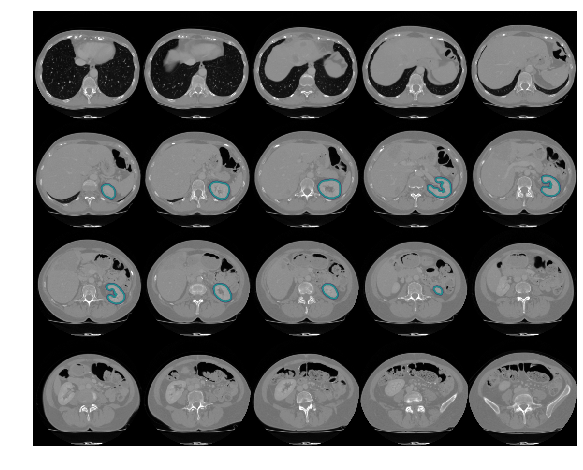

(None,)

In [13]:
data3d, true_segmentation, seeds, voxelsize_mm, orig_vs_mm = prepare_data(1, "left_kidney")
plt.figure(figsize=(10,8))
# sed3.show_slices(data3d, seeds=seeds, contour=true_segmentation, shape=[3, 4])

plt.axis("off")
sed3.show_slices(
    data3d, 
#     seeds=seeds, 
    contour=(true_segmentation > 0).astype(np.int) * 2, 
    shape=[4, 5]), 
#     show=False

In [14]:
# help(sed3.show_slices)

In [15]:

datap["processing_information"]["organ_segmentation"].keys()

dict_keys(['processing_time', 'time_start', 'oseg_input_params', 'organ_interactivity_counter', 'seeds'])

# Data screenshots

Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


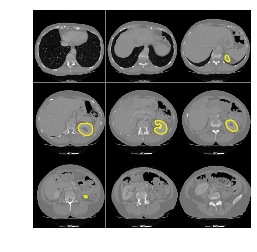

In [16]:

img, seg, seeds, voxelsize_mm, orig_vs_mm = prepare_data(1, "left_kidney")
# plt.figure(figsize=(10,15))
plt.figure()
import copy
imgview = copy.copy(img)
imgview[:,:,-1] = 0
imgview[:,-1,:] = 0
imgview[-1,:,:] = 0
# sed3.show_slices(imgview, contour=seg, seeds=seeds, show=False, slice_step=16.9, first_slice_offset_to_see_seed_with_label=2)
sed3.show_slices(imgview, 
                 contour=(true_segmentation > 0).astype(np.int) * 3, 
                 show=False, shape=[3,3], 
#                  first_slice_offset_to_see_seed_with_label=2
                )
plt.axis("off")
# plt.savefig("../graphics/msgc-ct-imgsample_separated.png")

plt.savefig(
    latex_dir / "ircadb01_slices_uncropped.png", 
    dpi=dpi, bbox_inches='tight')

In [17]:
np.unique(seeds)

array([0, 1, 2], dtype=uint8)

### LaTeX export functions

In [18]:
def to_latex_file(df, fn):
    with open(fn, "w") as f:
        f.write(df.to_latex())
        
def latex_float(f, precision=4):
    float_str = "{0:." + str(int(precision)) + "g}"
    float_str = float_str.format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def float_to_latex_file(fl, fn, precision=4):
    string = latex_float(fl, precision=precision)
    with open(fn, "w") as f:
        f.write(string)

def num2latex(num, filename=None, precision=4):
    if type(num) is str:
        float_str = num
    else:
        float_str = "{0:." + str(int(precision)) + "g}"
        float_str = float_str.format(num)
        
    if float_str[:4] == r"\num":
        pass
    else:
        float_str = "\\num{" + float_str + "}" 
    if filename is not None:
        with open(filename, "w") as f:
            f.write(float_str)
    return float_str

def to_file(text, fn):
    with open(fn, "w") as f:
        f.write(text)

## CT data, opakovaný experiment

In [19]:
def process_gc_stats(stats1, prefix=None):
    if prefix is None:
        prefix = ""
    
        
    outstats = {}
    for key in stats1:
        outstats[prefix + key] = stats1[key]
        
    outstats[prefix + "nlinks number"] = np.sum(np.asarray(outstats[prefix + "nlinks shape"]), axis=0)[0]
    outstats[prefix + "tlinks number"] = np.sum(np.asarray(outstats[prefix + "tlinks shape"]), axis=0)[0]
    outstats.pop(prefix + "tlinks shape")
    outstats.pop(prefix + "nlinks shape")
    outstats[prefix + "edge number"] = outstats[prefix + "nlinks number"] + outstats[prefix + "tlinks number"]

    return outstats

    
def merge_stats(stats0, stats1, stats2, labels=None):
    if labels is None:
        labels = [""] * 3
    
   
    stats0 = process_gc_stats(stats0, labels[0])
    stats1 = process_gc_stats(stats1, labels[1])
    stats2 = process_gc_stats(stats2, labels[2])
    stats = {}
    stats.update(stats0)
    stats.update(stats1)
    stats.update(stats2)

    
    return stats

def run_gc_with_defined_setup(img, segparams, seeds, true_seg, dry_run=False):
    
    start = time.time()
    gc = pycut.ImageGraphCut(img, segparams=segparams)
    gc.set_seeds(seeds)
    if dry_run:
        thr = np.mean([np.min(img), np.max(img)])
        sg1 = (img < thr).astype(np.uint8)
        stats1 = {"nlinks shape": [[5, 5]], "tlinks shape": [[5, 5]]}
    else:
        gc.run()
        sg1 = gc.segmentation
        stats1 = gc.stats
    elapsed1 = (time.time() - start)
    err1 = np.sum(np.abs(true_seg - (1 - sg1)))
    stats1["time"] = elapsed1
    stats1["error"] = err1
    stats1["data segmentation size px"] = np.sum(sg1 > 0)
    return stats1


def add_data_and_algoritm_info(stats, data_params_dict, segparams, start, true_segmentation, voxelsize_mm, orig_vs_mm):
    #     stats['msgc time'] = elapsed1
#     stats['normal time'] = elapsed2
#     stats['data id'] = data_params[0]
#     stats['data offset'] = data_params[1]
#     stats['target organ'] = data_params[1]
#     stats['data radius'] = data_params[2]
#     stats['data size'] = data_params[0]
    stats.update(data_params_dict)
    stats["data size 0"] = true_segmentation.shape[0]
    stats["data size 1"] = true_segmentation.shape[1]
    stats["data size 2"] = true_segmentation.shape[2]
    stats["data size px"] = np.prod(true_segmentation.shape)
    stats["data target size px"] = np.sum(true_segmentation > 0)
    stats["data voxelsize mm^3"] = np.prod(voxelsize_mm)
    stats["data voxelsize mm 0"] = voxelsize_mm[0]
    stats["data voxelsize mm 1"] = voxelsize_mm[1]
    stats["data voxelsize mm 2"] = voxelsize_mm[2]
    stats["data orig voxelsize mm 0"] = orig_vs_mm[0]
    stats["data orig voxelsize mm 1"] = orig_vs_mm[1]
    stats["data orig voxelsize mm 2"] = orig_vs_mm[2]
    stats["block size"] = segparams["block_size"]
#     stats["data seedsz"] = data_params[3]
#     stats["GC error"] = err2
#     stats["MSGC error"] = err1
    stats['machine hostname'] = machine_hostname
    stats['experiment iteration start time'] = start
    
    return stats

def add_data_seaborn(stats, data_params_dict, segparams, start, i, label, true_segmentation, voxelsize_mm, orig_vs_mm):
    stats = process_gc_stats(stats, "")
    stats = add_data_and_algoritm_info(stats, data_params_dict, segparams, start, true_segmentation, voxelsize_mm, orig_vs_mm)
    stats["method"] = label
    dfinew = pd.DataFrame(stats, index=[i*3 + 0])
    #dfnew = dfnew.append(dfinew, sort=True)
    
    return dfinew

In [20]:
#for par in it:
#    print par
i = 0

In [21]:
if op.exists(fname) and not force_rewrite:
    df = pd.read_csv(fname)#, index_col=0)
else:
    df = pd.DataFrame([])
    
if op.exists(fnamenew) and not force_rewrite:
    dfnew = pd.read_csv(fnamenew)#, index_col=0)
else:
    dfnew = pd.DataFrame([])


i = 0
np.random.seed(rnd_seed)

import platform
machine_hostname = platform.node()

# it = itertools.product(dp_ircad_id, dp_keys)
it = itertools.product(dp_ircad_id_key)
for data_params in it:
# dp_ircad_id = [1, 10, 11]
# dp_keys = ["left_kidney"]

    start = time.time()
    img, true_seg, seeds, voxelsize_mm, orig_vs_mm = prepare_data(data_params[0], data_params[1])
    stats0 = run_gc_with_defined_setup(img, segparams0, seeds, true_seg, dry_run=dry_run)
    stats1 = run_gc_with_defined_setup(img, segparams1, seeds, true_seg, dry_run=dry_run)
    stats2 = run_gc_with_defined_setup(img, segparams2, seeds, true_seg, dry_run=dry_run)

    
    data_params_dict = dict(zip(["data id", "data organ key"], data_params))
#     stats = merge_stats(stats0, stats1, stats2, labels)
#     stats = add_data_and_algoritm_info(stats, data_params_dict, segparams0, start, seg, voxelsize_mm)
    
#     dfi = pd.DataFrame(stats, index=[i])
    
#     # display(df)
#     df = df.append(dfi, sort=True)
#     df.to_csv(fname, index=False)
    
    dfinew = add_data_seaborn(stats0, data_params_dict, segparams0, start, i, labels[0], true_seg, voxelsize_mm, orig_vs_mm)
    dfnew = dfnew.append(dfinew, sort=True)
    dfinew = add_data_seaborn(stats1, data_params_dict, segparams1, start, i, labels[1], true_seg, voxelsize_mm, orig_vs_mm)
    dfnew = dfnew.append(dfinew, sort=True)
    dfinew = add_data_seaborn(stats2, data_params_dict, segparams2, start, i, labels[2], true_seg, voxelsize_mm, orig_vs_mm)
    dfnew = dfnew.append(dfinew, sort=True)
    
    dfnew.to_csv(fnamenew, index=False)
    
    i += 1
    

#     plt.figure(figsize=[10,15])
#     sed3.show_slices(img, contour=sg1, seeds=seeds, slice_step=10)
#     plt.figure(figsize=[10,15])
#     sed3.show_slices(img, contour=sg2, seeds=seeds, slice_step=10)

Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. U

In [22]:
np.unique(seeds)

array([0, 1, 2], dtype=uint8)

In [23]:
i

6

In [24]:
# export all to latex
dtt.save(dfnew, "raw_table")

In [25]:
stats0

{'tlinks shape': [(35311067, 2)],
 'nlinks shape': [(105610054, 3)],
 '_create_nlinks time': 27.883443117141724,
 'gc time': 658.4494686126709,
 'time': 700.6485996246338,
 'error': 13638081,
 'data segmentation size px': 34620298}

In [26]:
# gc

# Data processing graphs, statistics

In [27]:
df = pd.read_csv(fnamenew)
df.rename(columns={"msgc time": "MSGC time"})
# dfs = df[(df["data seedsz"]==3) & (df["data offset"] == 3) & (df["data radius"] == 10)]
# dfs_plus = dfs[dfs['data size'] > 160]
dfs = df

import seaborn as sns
sns.set_context("paper")
sns.set_style("white")

In [28]:
dfs.keys()

Index(['_create_nlinks time', 'block size', 'data id', 'data organ key',
       'data orig voxesize mm 0', 'data orig voxesize mm 1',
       'data orig voxesize mm 2', 'data segmentation size px', 'data size 0',
       'data size 1', 'data size 2', 'data size px', 'data target size px',
       'data voxesize mm 0', 'data voxesize mm 1', 'data voxesize mm 2',
       'data voxesize mm^3', 'edge number', 'error',
       'experiment iteration start time', 'gc time', 'low level image voxels',
       'low level object voxels', 'machine hostname', 'method',
       'nlinks number', 't graph 01', 't graph 10', 't graph 11', 't graph 13',
       't graph 14', 't graph high', 't graph low', 't split 01', 't split 02',
       't split 03', 't split 04', 't split 05', 't split 06', 't split 07',
       't split 08', 't split 081', 't split 082', 't split 0821',
       't split 09', 't split 10', 't1', 't10', 't2', 't3', 't3.1', 't3.2',
       't3.3', 't4', 't5', 't6', 't7', 't8', 't9', 'time', 'tli

In [29]:

dfs

,_create_nlinks time,block size,data id,data organ key,data orig voxesize mm 0,data orig voxesize mm 1,data orig voxesize mm 2,data segmentation size px,data size 0,data size 1,...,t3.2,t3.3,t4,t5,t6,t7,t8,t9,time,tlinks number
0,5.766579,10,1,left_kidney,1.6,0.570000,0.570000,7899696,159,225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.486965,8049375
1,2.253976,10,1,left_kidney,1.6,0.570000,0.570000,7958982,159,225,...,NaN,NaN,2.202110,4.526894,13.892885,21.441667,43.985390,44.034261,58.131531,2153571
2,0.004987,10,1,left_kidney,1.6,0.570000,0.570000,7953037,159,225,...,0.485666,227.106728,227.106728,229.774595,230.287257,230.287257,NaN,230.415882,239.389953,2515427
3,8.892193,10,5,left_kidney,1.6,0.782000,0.782000,16002264,172,308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.103456,16316608
4,3.779895,10,5,left_kidney,1.6,0.782000,0.782000,16072293,172,308,...,NaN,NaN,3.491663,7.412213,23.513129,36.919284,74.184645,74.247510,99.370304,4746648
5,0.006981,10,5,left_kidney,1.6,0.782000,0.782000,16069107,172,308,...,0.781909,592.355162,592.355162,597.108421,598.019982,598.019982,NaN,598.240394,614.604673,4255371
6,8.848342,10,6,left_kidney,1.6,0.782000,0.782000,15510422,167,308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124.833223,15842288
7,3.644224,10,6,left_kidney,1.6,0.782000,0.782000,15644231,167,308,...,NaN,NaN,3.202471,6.996336,22.665397,39.062556,73.092567,73.162410,104.594336,5624068
8,0.004986,10,6,left_kidney,1.6,0.782000,0.782000,15643220,167,308,...,0.772932,977.186014,977.187012,981.809653,982.652398,982.652398,NaN,982.918688,1007.032177,5477224
9,10.910827,10,7,left_kidney,1.6,0.782000,0.782000,17330866,186,308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175.228526,17644704


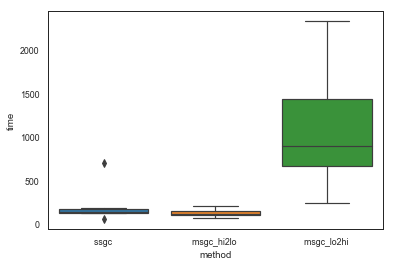

In [30]:
sns.boxplot(data=df, y="time", x="method")

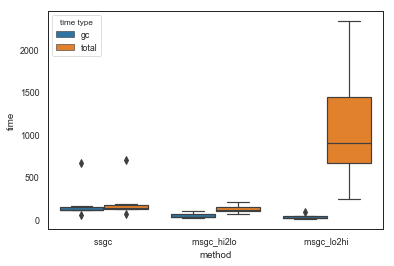

In [31]:
uu = pd.melt(df.rename(columns={"gc time": "gc", "time": "total"}), value_vars=["gc", "total"], id_vars=["method"], var_name="time type", value_name="time")
sns.boxplot(data=uu, hue="time type",y="time", x="method")
plt.savefig(op.join(latex_dir, "msgc_time_boxplot_ct.pdf"), dpi=1000)

In [32]:
# uu["method"] == "msgc_lo2hi"
uu[uu["method"] == "msgc_lo2hi "]


,method,time type,time
2,msgc_lo2hi,gc,7.987640
5,msgc_lo2hi,gc,14.618911
8,msgc_lo2hi,gc,22.565665
11,msgc_lo2hi,gc,19.598596
14,msgc_lo2hi,gc,82.400678
17,msgc_lo2hi,gc,43.752438
20,msgc_lo2hi,total,239.389953
23,msgc_lo2hi,total,614.604673
26,msgc_lo2hi,total,1007.032177
29,msgc_lo2hi,total,784.689900


In [33]:
table = pd.pivot_table(
    dfs, values=['gc time', 'time', "t3", "t4", "t5", "t6", "t7", "t8"], index=['method'], 
    aggfunc={'gc time': np.mean, 'time': [np.mean, min, max], "t3": np.mean,"t4": np.mean, "t5": np.mean, "t6": np.mean, "t7": np.mean, "t8": np.mean}
)
table

gc time        t3           t4           t5           t6  \
                   mean      mean         mean         mean         mean   
method                                                                     
msgc_hi2lo    41.811891  0.485222     3.505989     7.941802    24.545930   
msgc_lo2hi    31.820655  0.596543  1054.064100  1059.092315  1060.065712   
ssgc         200.208196       NaN          NaN          NaN          NaN   

                      t7         t8         time                           
                    mean       mean          max         mean         min  
method                                                                     
msgc_hi2lo     40.928017  77.838642   197.966729   121.498467   58.131531  
msgc_lo2hi   1060.065712        NaN  2334.101257  1093.940190  239.389953  
ssgc                 NaN        NaN   700.648600   219.261072   56.486965

In [34]:
table = pd.pivot_table(
    dfs, values=['gc time', 'time', "t2", "t3", "t3.1", "t3.2", "t3.3", "t4", "t5", "t6", "t7", "t8", "low level image voxels", "low level object voxels"], index=['method'], 
    aggfunc=np.min
)
table

,gc time,low level image voxels,low level object voxels,t2,t3,t3.1,t3.2,t3.3,t4,t5,t6,t7,t8,time
method,,,,,,,,,,,,,,
msgc_hi2lo,13.063071,8464.0,38.0,0.263294,0.267288,NaN,NaN,NaN,2.202110,4.526894,13.892885,21.441667,43.98539,58.131531
msgc_lo2hi,7.987640,8464.0,45.0,0.335105,0.340055,0.340055,0.485666,227.106728,227.106728,229.774595,230.287257,230.287257,NaN,239.389953
ssgc,46.332080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.486965


In [35]:
table = pd.pivot_table(
    dfs, values=['gc time', 'time', "t graph 01", "t graph 10", "t graph 11", "t graph 13", "t graph 14", "low level image voxels", "low level object voxels"], index=['method'], 
    aggfunc=np.mean
)
table

,gc time,low level image voxels,low level object voxels,t graph 01,t graph 10,t graph 11,t graph 13,t graph 14,time
method,,,,,,,,,
msgc_hi2lo,41.811891,18415.833333,225.166667,NaN,NaN,NaN,NaN,NaN,121.498467
msgc_lo2hi,31.820655,18415.833333,230.333333,0.254824,0.25898,0.259645,1052.582909,1053.466392,1093.940190
ssgc,200.208196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219.261072


In [36]:
table = pd.pivot_table(
    dfs, values=[
        'gc time', 'time',  
        "t graph low",
        "t graph high",
        "t split 01",
        "t split 02",
        "t split 03",
        "t split 04",
        "t split 05",
        "t split 06",
        "t split 07",
        "t split 08",
        "t split 081",
        "t split 082",
        "t split 09",
        "t split 10",
        "low level image voxels", "low level object voxels"], index=['method'], 
    aggfunc=np.mean
)
table

,gc time,low level image voxels,low level object voxels,t graph high,t graph low,t split 01,t split 02,t split 03,t split 04,t split 05,t split 06,t split 07,t split 08,t split 081,t split 082,t split 09,t split 10,time
method,,,,,,,,,,,,,,,,,,
msgc_hi2lo,41.811891,18415.833333,225.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.498467
msgc_lo2hi,31.820655,18415.833333,230.333333,1052.120787,0.171895,0.002,0.019803,0.044086,0.296497,0.30996,0.649394,1.001618,416.392635,0.0,0.0,712.456573,1009.965425,1093.940190
ssgc,200.208196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219.261072


In [37]:
dfs.keys()

Index(['_create_nlinks time', 'block size', 'data id', 'data organ key',
       'data orig voxesize mm 0', 'data orig voxesize mm 1',
       'data orig voxesize mm 2', 'data segmentation size px', 'data size 0',
       'data size 1', 'data size 2', 'data size px', 'data target size px',
       'data voxesize mm 0', 'data voxesize mm 1', 'data voxesize mm 2',
       'data voxesize mm^3', 'edge number', 'error',
       'experiment iteration start time', 'gc time', 'low level image voxels',
       'low level object voxels', 'machine hostname', 'method',
       'nlinks number', 't graph 01', 't graph 10', 't graph 11', 't graph 13',
       't graph 14', 't graph high', 't graph low', 't split 01', 't split 02',
       't split 03', 't split 04', 't split 05', 't split 06', 't split 07',
       't split 08', 't split 081', 't split 082', 't split 0821',
       't split 09', 't split 10', 't1', 't10', 't2', 't3', 't3.1', 't3.2',
       't3.3', 't4', 't5', 't6', 't7', 't8', 't9', 'time', 'tli